# 2022-02-18 • Scale up N and duration

## Setup

In [75]:
# Pkg.resolve()

In [76]:
include("nb_init.jl")

[ Info: using Revise
[ Info: import Distributions
[ Info: import MyToolbox
[ Info: using VoltageToMap


In [77]:
using Parameters, ComponentArrays
@alias CVec = ComponentVector;

## Parameters

### Simulation duration

In [78]:
sim_duration = 1.2 * seconds;

### Input spike trains

In [79]:
N_unconn = 100
N_exc    = 800
# N_exc    = 5200
N_inh    = N_exc ÷ 4

200

In [80]:
N_conn = N_inh + N_exc

1000

In [81]:
N = N_conn + N_unconn

1100

In [82]:
input_spike_rate = LogNormal_with_mean(4Hz, √0.6)  # See the previous notebook

LogNormal{Float64}(μ=1.0862943611198905, σ=0.7745966692414834)

### Synapses

Reversal potential at excitatory and inhibitory synapses,
as in the report [`2021-11-11__synaptic_conductance_ratio.pdf`](https://github.com/tfiers/phd-thesis/blob/main/reports/2021-11-11__synaptic_conductance_ratio.pdf):

In [83]:
E_exc =   0 * mV
E_inh = -65 * mV;

Synaptic conductances `g` at `t = 0`

In [84]:
g_t0 = 0 * nS;

Exponential decay time constant of synaptic conductance, $τ_{s}$ (`s` for "synaptic")

In [85]:
τ_s = 7 * ms;

Increase in synaptic conductance on a presynaptic spike

In [86]:
Δg_exc = 0.1 * nS
Δg_inh = 0.4 * nS;

### Izhikevich neuron

Initial membrane potential `v` and adaptation variable `u` values

In [87]:
v_t0  = -80 * mV
u_t0  =   0 * pA;

Izhikevich's neuron model parameters for a cortical regular spiking neuron:

In [88]:
cortical_RS = CVec(
    C      = 100 * pF,
    k      = 0.7 * (nS/mV),  # steepness of dv/dt's parabola
    vr     = -60 * mV,
    vt     = -40 * mV,
    a      = 0.03 / ms,      # 1 / time constant of `u`
    b      = -2 * nS,        # how strongly `v` deviations from `vr` increase `u`.
    v_peak =  35 * mV,
    c      = -50 * mV,       # reset voltage.
    d      = 100 * pA,       # `u` increase on spike. Free parameter.
);

### Numerics

Whether to use a fixed (`false`) or [adaptive](https://www.wikiwand.com/en/Adaptive_step_size) timestep (`true`).

In [89]:
adaptive = true;

Timestep. If `adaptive`, size of first time step.

In [90]:
dt    = 0.1 * ms;

Minimum and maximum step sizes

In [91]:
dtmax = 0.5  * ms  # solution unstable if not set
dtmin = 0.01 * ms;  # don't spend too much time finding thr crossing or spike arrival

Error tolerances used for determining step size, if `adaptive`.

The solver guarantees that the (estimated) difference between
the numerical solution and the true solution at any time step
is not larger than `abstol + reltol * |y|`
(where `y` ≈ the numerical solution at that time step).

In [92]:
abstol_v = 0.1 * mV
abstol_u = 0.1 * pA
abstol_g = 0.01 * nS;

In [93]:
reltol = 1e-3;  # e.g. if true sol is -80 mV, then max error of 0.08 mV
reltol = 1;     # only use abstol

In [94]:
tol_correction = 0.1;

In [95]:
(abstol_v, abstol_u, abstol_g) .* tol_correction

(1.0e-5, 1.0000000000000002e-14, 1.0000000000000002e-12)

For comparison, the default tolerances for ODEs in DifferentialEquations.jl are
- `reltol = 1e-2`
- `abstol = 1e-6`.

## IDs

Neuron, synapse & simulated variable IDs.

In [96]:
"""
    idvec(A = 4, B = 2, …)

Build a `ComponentVector` (CVec) with the given group names and
as many elements per group as specified. Each element gets a
unique ID within the CVec, which is also its index in the CVec.
I.e. the above call yields `CVec(A = [1,2,3,4], B = [5,6])`.
Specify `nothing` as size for a scalar element. Example:
`idvec(A=nothing, B=1)` → `CVec(A=1, B=[2])`
"""
function idvec(; kw...)
    cvec = CVec(; (name => _expand(val) for (name, val) in kw)...)
    cvec .= 1:length(cvec)
    return cvec
end;

temp = -1  # value does not matter; they get overwritten by UnitRange
_expand(val::Nothing) = temp
_expand(val::Integer) = fill(temp, val)
_expand(val::CVec)    = val              # allow nested idvecs
;

In [97]:
input_neurons = idvec(conn = idvec(exc = N_exc, inh = N_inh), unconn = N_unconn)

ComponentVector{Int64}(conn = (exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  791, 792, 793, 794, 795, 796, 797, 798, 799, 800], inh = [801, 802, 803, 804, 805, 806, 807, 808, 809, 810  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]), unconn = [1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010  …  1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100])

In [98]:
synapses = idvec(exc = N_exc, inh = N_inh)

ComponentVector{Int64}(exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  791, 792, 793, 794, 795, 796, 797, 798, 799, 800], inh = [801, 802, 803, 804, 805, 806, 807, 808, 809, 810  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000])

In [99]:
simulated_vars = idvec(v = nothing, u = nothing, g = synapses)

ComponentVector{Int64}(v = 1, u = 2, g = (exc = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12  …  793, 794, 795, 796, 797, 798, 799, 800, 801, 802], inh = [803, 804, 805, 806, 807, 808, 809, 810, 811, 812  …  993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002]))

## Connections

In [103]:
postsynapses = Dict{Int, Vector{Int}}()  # input_neuron_ID => [synapse_IDs...]

for (n, s) in zip(input_neurons.conn, synapses)
    postsynapses[n] = [s]
end
for n in input_neurons.unconn
    postsynapses[n] = []
end

## Broadcast parameters

In [104]:
Δg = similar(synapses, Float64)
Δg.exc .= Δg_exc
Δg.inh .= Δg_inh;

In [105]:
E = similar(synapses, Float64)
E.exc .= E_exc
E.inh .= E_inh;

Initial conditions

In [106]:
vars_t0 = similar(simulated_vars, Float64)
vars_t0.v = v_t0
vars_t0.u = u_t0
vars_t0.g .= g_t0;

Maximum error

In [107]:
abstol = similar(simulated_vars, Float64)
abstol.v = abstol_v
abstol.u = abstol_u
abstol.g .= abstol_g
abstol = abstol .* tol_correction;

## ISI distributions

Generate firing rates $λ$ by sampling from the input spike rate distribution.

In [108]:
λ = similar(input_neurons, Float64)
λ .= rand(input_spike_rate, length(λ));
# showsome(λ)

`Distributions.jl` uses an alternative `Exp` parametrization, namely scale $β$ = 1 / rate.

In [109]:
β = 1 ./ λ;

In [110]:
ISI_distributions = similar(input_neurons, Exponential{Float64})
ISI_distributions .= Exponential.(β);

## Initialize spiking

Generate the first spike time for every input neuron by sampling once from its ISI distribution.

In [111]:
first_spike_times = rand.(ISI_distributions);

Sort these initial spike times by building a priority queue.

In [112]:
upcoming_input_spikes = PriorityQueue{Int, Float64}();

In [113]:
for (neuron, first_spike_time) in enumerate(first_spike_times)
    enqueue!(upcoming_input_spikes, neuron => first_spike_time)
end

## `p` object

In [114]:
params = (;
    E, Δg, τ_s,
    izh = cortical_RS,
    postsynapses,
    ISI_distributions,
    upcoming_input_spikes,
);

## Differential equations

The derivative functions that define the differential equations.  
Note that discontinuities are defined in the next section.

In [487]:
function f(D, vars, params, _)
    @unpack v, u, g = vars
    @unpack E, τ_s, izh = params
    @unpack C, k, vr, vt, a, b = izh
    I_s = 0.0
    for (gi, Ei) in zip(g, E)
        I_s += gi * (v - Ei)
    end
    D.v = (k * (v - vr) * (v - vt) - u - I_s) / C
    D.u = a * (b * (v - vr) - u)
    D.g .= .-g ./ τ_s
    return nothing
end;

In [488]:
vars = vars_t0
D = similar(vars);

In [490]:
f(D, vars, params, nothing)
@time f(D, vars, params, nothing)

  0.000018 seconds (3 allocations: 128 bytes)


In [517]:
function f2(D,vars,params)
    @unpack v, u, g = vars
    @unpack E, τ_s, izh = params
    @unpack C, k, vr, vt, a, b = izh;
    I_s = 0.0
    for (gi, Ei) in zip(g, E)
        I_s += gi * (v - Ei)
    end
    D.v = (k * (v - vr) * (v - vt) - u - I_s) / C
    D.u = a * (b * (v - vr) - u)
    for i in 1:length(g)
        D.g[i] = -g[i] / τ_s
    end
    return nothing
end;

In [518]:
f2(D,vars,params)
@time f2(D,vars,params)

  0.000010 seconds


nice. so D.g should be loop, for no alloc at all. Even `@.` didn't help

## Events

In [46]:
"""
An `Event` encapsulates two functions that determine when and
how to introduce discontinuities in the differential equations:

- `distance` returns some distance to the next event.
   An event occurs when this distance hits zero.
- `on_event!` is called at each event and may modify
   the simulated variables and the parameter object.

Both functions take the parameters `(vars, params, t)`: the simulated
variables, the parameter object, and the current simulation time.
"""
struct Event
    distance
    on_event!
end;

Input spike generation (== arrival, because no transmission delay):

In [665]:
function time_to_next_input_spike(vars, params, t)
    _, next_input_spike_time = peek(params.upcoming_input_spikes)
    return t - next_input_spike_time
end;

In [666]:
t_ = 0.1s;

In [667]:
time_to_next_input_spike(vars, params, t_)
@time time_to_next_input_spike(vars, params, t_);

  0.000007 seconds (1 allocation: 16 bytes)


The one alloc is for the return value. We hope this function gets inlined where it's used (`condition`).

In [668]:
function on_input_spike!(vars, params, t)
    # Process the neuron that just fired.
    # Start by removing it from the queue.
    fired_neuron = dequeue!(params.upcoming_input_spikes)
    
    # Generate a new spike time, and add it to the queue.
    new_spike_time = t + rand(params.ISI_distributions[fired_neuron])
    enqueue!(params.upcoming_input_spikes, fired_neuron => new_spike_time)
    
    # Update the downstream synapses
    # (number of these synapses in the N-to-1 case: 0 or 1).
    for synapse in params.postsynapses[fired_neuron]
        vars.g[synapse] += params.Δg[synapse]
    end

end

input_spike = Event(time_to_next_input_spike, on_input_spike!);

In [669]:
on_input_spike!(vars, params, t_)
@time on_input_spike!(vars, params, t_);

  0.000019 seconds


Nice! no allocs already

Spike threshold crossing of Izhikevich neuron  

In [670]:
distance_to_v_peak(vars, params, _) = vars.v - params.izh.v_peak;

In [671]:
distance_to_v_peak(vars, params, t_)
@time distance_to_v_peak(vars, params, t_);

  0.000005 seconds (1 allocation: 16 bytes)


same thang, return val.

In [672]:
function on_v_peak!(vars, params, _)
    # The discontinuous LIF/Izhikevich/AdEx update
    vars.v = params.izh.c
    vars.u += params.izh.d
    return nothing
end

spiking_threshold_crossing = Event(distance_to_spiking_threshold, on_spiking_threshold_crossing!);

In [673]:
on_v_peak!(vars, params, t_)
@time on_v_peak!(vars, params, t_);

  0.000006 seconds


I added `return nothing` so no alloc.

In [674]:
events = [input_spike, spiking_threshold_crossing];

## diffeq.jl API

Set-up problem and solution in DifferentialEquations.jl's API.

In [675]:
@withfeedback using OrdinaryDiffEq

[ Info: using OrdinaryDiffEq


In [676]:
prob = ODEProblem(f, vars_t0, float(sim_duration), params);

In [677]:
function condition(distance, vars, t, integrator)
    for (i, event) in enumerate(events)
        distance[i] = event.distance(vars, integrator.p, t)
    end
end;

In [678]:
distance = zeros(2)
integrator = (p = params,);

In [679]:
condition(distance, vars, t_, integrator)
@time condition(distance, vars, t_, integrator);

  0.000014 seconds (19 allocations: 624 bytes)


In [680]:
integrator = (;params, events);

In [681]:
function c2(distance, vars, t, int)
    for i in 1:10 end   # no alloc
    # for i in 1:length(events) end  # 3 allocs!! 100 byte
    for i in 1:length(int.events) end  # no alloc :)   (thanks to no global)
    for (i, event) in enumerate(int.events)
        # distance[i] = event.distance(vars, int.params, t)  # 8 allocs, 256 bytes
    end
end;

In [682]:
c2(distance, vars, t_, integrator)
@time c2(distance, vars, t_, integrator);

  0.000012 seconds (8 allocations: 256 bytes)


In [696]:
@time events[1].distance(vars, integrator.params, t_);

  0.000018 seconds (5 allocations: 240 bytes)


In [697]:
@time events[1].distance(vars, params, t_);

  0.000013 seconds (3 allocations: 80 bytes)


In [700]:
@time time_to_next_input_spike(vars, params, t_);

  0.000007 seconds (1 allocation: 16 bytes)


In [ ]:
function affect!(integrator, i)
    events[i].on_event!(integrator.u, integrator.p, integrator.t)
end

In [52]:
callback = VectorContinuousCallback(condition, affect!, length(events));

In [53]:
solver = Tsit5()

Tsit5(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))

In [54]:
save_idxs = [simulated_vars.v, simulated_vars.u];

In [55]:
progress = true;

In [56]:
solve_() = solve(
    prob, solver;
    callback, save_idxs, progress,
    adaptive, dt, dtmax, dtmin, abstol, reltol,
);

## Solve

In [57]:
sol = @time solve_();

 16.172403 seconds (24.21 M allocations: 1.162 GiB, 5.96% gc time, 88.36% compilation time)


In [53]:
sol = @time solve_();

 12.388856 seconds (23.88 M allocations: 1.152 GiB, 4.50% gc time, 89.20% compilation time)


## Plot

In [58]:
@withfeedback import PyPlot
using Sciplotlib

[ Info: import PyPlot


In [62]:
""" t = [200ms, 600ms] e.g. """
function Sciplotlib.plot(sol::ODESolution; t = nothing)
    isnothing(t) && (t = sol.t[[1,end]])
    izoom = first(t) .< sol.t .< last(t)
    plot(
        sol.t[izoom] / ms,
        sol[1,izoom] / mV,
        clip_on = false,
        marker = ".", ms = 1.2, lw = 0.4,
        #  xlim = t,  # haha lolwut, adding this causes fig to no longer display.
    )
end;

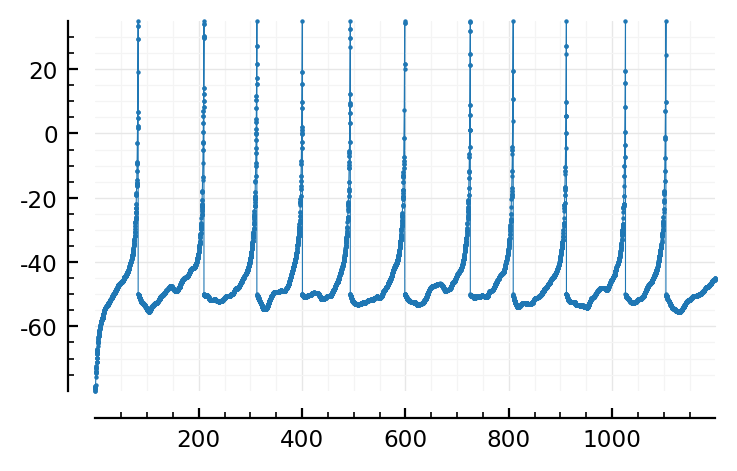

In [63]:
plot(sol);